In [1]:
from lightgbm import LGBMRegressor,LGBMClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression
from xgboost import XGBRegressor,XGBClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,f1_score,precision_score,recall_score

from sklearnex import patch_sklearn,unpatch_sklearn

from scipy.stats import f_oneway

import gc
import pickle

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter

from Interaction_effect_features import get_data

from MetaHeuristicsFS import FeatureSelection

# from EvolutionaryFS import GeneticAlgorithmFS
# from SimmulatedAnnealingFS import SimulatedAnnealingFS
# from ACO import AntColonyOptimizationFS
# from PSOFinal import ParticleSwarmOptimizationFS

import shap

np.seterr(divide = 'ignore')
pd.options.mode.chained_assignment = None  # default='warn'
import warnings
# suppress warnings
warnings.filterwarnings('ignore')

In [2]:
def get_metrics(model,data_dict,problem_type,dependent_variable,features,cost_funct):
    '''
    problem_type = 'regression' or classification
    '''
    
    test_tree_cost = {}
    
    external_tree_cost = []
    external_tree_precision = []
    external_tree_recall = []
    
    data_external_test = data_dict['data_external_test']
    data_validation_test = data_dict['data_validation_test']
    
    #for each training data
    for data_fold_index in data_dict['fold_dict'].keys():
        fold_training = data_dict['fold_dict'][data_fold_index]['fold_training']
        fold_test = data_dict['fold_dict'][data_fold_index]['fold_test']
        
        #based on regression/classification
        if problem_type == 'regression':
            cost_function = cost_funct
        else:
            cost_function = f1_score
        
        Y_train = fold_training[dependent_variable]
        Y_test = fold_test[dependent_variable]
        Y_validation = data_validation_test[dependent_variable]
        Y_external = data_external_test[dependent_variable]
        
        model.fit(fold_training[features],Y_train)
                
        Y_test_tree = model.predict(fold_test[features])
        Y_validation_tree = model.predict(data_validation_test[features])
        Y_external_tree = model.predict(data_external_test[features])
        
        place_holder = np.mean([cost_funct(Y_test,Y_test_tree),cost_funct(Y_validation,Y_validation_tree)])
        
        #predict for test and calculate cost function
        test_tree_cost['CV Sample-'+str(data_fold_index)] = place_holder

        #predict for external test and calculate cost function
        external_tree_cost.append(cost_funct(Y_external,Y_external_tree))
        
        if problem_type != 'regression':
            external_tree_precision.append(precision_score(Y_external,Y_external_tree))
            external_tree_recall.append(recall_score(Y_external,Y_external_tree))
            
    #return cost
    if problem_type != 'regression':
        #print('External Test precision: ' + str(round(np.mean(external_tree_precision),2)) + ', recall: ' + str(round(np.mean(external_tree_recall),2)))
        print('External Test recall: ' + str(round(np.mean(external_tree_recall),2)))
    return test_tree_cost,external_tree_cost

In [3]:
def make_plot(metric,title,test_tree_cost,external_tree_cost):
    sns.set(rc={'figure.figsize':(16,8)})
    sns.set_context('paper', font_scale = 1.3)
    if metric=='RMSE':
        fig, ax = plt.subplots(1, 2)
    else:
        fig, ax = plt.subplots(1, 2, sharey=True)
        
    validation_name = [' External_Test','External_Test ',' External_Test ',' External_Test  ','  External_Test']

    ax[0].bar(list(test_tree_cost.keys()),list(test_tree_cost.values()))
    ax[0].set_title(metric + ' for test data and validation data')

    ax[1].bar(validation_name,external_tree_cost)
    ax[1].set_title(metric + ' for external test data')

    #plt.title('')
    
def get_data_for_FS(data_dict,dependent_variable,features_all):
    
    data_dict_for_SA = {}

#     x_validation = data_dict['data_external_test'][features_all]
#     y_validation = data_dict['data_external_test'][dependent_variable]
    
    x_validation = data_dict['data_validation_test'][features_all]
    y_validation = data_dict['data_validation_test'][dependent_variable]

    #for each training data
    for data_fold_index in data_dict['fold_dict'].keys():
        
        for feature in features_all:
            if feature not in data_dict['fold_dict'][data_fold_index]['fold_training'].columns:
                print(feature,'not present')

        data_dict_for_SA[data_fold_index]={'x_train':data_dict['fold_dict'][data_fold_index]['fold_training'][features_all],
                                           'y_train':data_dict['fold_dict'][data_fold_index]['fold_training'][dependent_variable],
                                           'x_test':data_dict['fold_dict'][data_fold_index]['fold_test'][features_all],
                                           'y_test':data_dict['fold_dict'][data_fold_index]['fold_test'][dependent_variable]}
    
#     for feature in features_all:
#         if '_Encoded' not in feature:
            
    
    return data_dict_for_SA,x_validation,y_validation,features_all

def last_preprocessing(data_dict):
    
    columns = ['LeadTime_Quartile_countEncoded','LeadTime_Quartile_percentEncoded','LeadTime_Quartile_countRankEncoded','LeadTime_Quartile_MeanEncoded','ADR_Quartile_countEncoded','ADR_Quartile_percentEncoded','ADR_Quartile_countRankEncoded','ADR_Quartile_MeanEncoded']

    for feature in columns:
        data_dict['data_external_test'][feature] = data_dict['data_external_test'][feature].astype(int)
        data_dict['data_validation_test'][feature] = data_dict['data_validation_test'][feature].astype(int)
        
        for index in data_dict['fold_dict'].keys():
            data_dict['fold_dict'][index]['fold_training'][feature] = data_dict['fold_dict'][index]['fold_training'][feature].astype(int)
            data_dict['fold_dict'][index]['fold_test'][feature] = data_dict['fold_dict'][index]['fold_test'][feature].astype(int)


    return data_dict

def last_preprocessing_linear(data_dict):
    
    columns = ['LeadTime_Quartile_countEncoded','LeadTime_Quartile_percentEncoded','LeadTime_Quartile_countRankEncoded','LeadTime_Quartile_MeanEncoded','ADR_Quartile_countEncoded','ADR_Quartile_percentEncoded','ADR_Quartile_countRankEncoded','ADR_Quartile_MeanEncoded']
    for feature in columns:
        data_dict['data_external_test'][feature] = data_dict['data_external_test'][feature].astype(int)
        data_dict['data_validation_test'][feature] = data_dict['data_validation_test'][feature].astype(int)
        
        for index in data_dict['fold_dict'].keys():
            data_dict['fold_dict'][index]['fold_training'][feature] = data_dict['fold_dict'][index]['fold_training'][feature].astype(int)
            data_dict['fold_dict'][index]['fold_test'][feature] = data_dict['fold_dict'][index]['fold_test'][feature].astype(int)


    return data_dict


def cost_funct(y_true,y_pred):
    return precision_score(y_true,y_pred)
    
    

In [4]:
def anova_fs(linear_features_all,data_dict,dependent_variable):
    
    common_list = []
    
    for feature in linear_features_all:
        
        p_counter = 0
        
        for index in data_dict['fold_dict'].keys():
            
            indx_df = data_dict['fold_dict'][index]['fold_training']
            
            class1 = indx_df[indx_df[dependent_variable[0]]==1][feature]
            class2 = indx_df[indx_df[dependent_variable[0]]==0][feature]
            
            stat,p = f_oneway(class1, class2)
            
            if p <= 0.05:
                p_counter += 1
        
        if p_counter == 5:
            common_list.append(feature)
        
    return common_list

## Hotel Cancellations

In [5]:
problem = 'HotelCancellations'
data_dict,dependent_variable,categorical_linear,categorical_tree,categorical_features,numerical_features_linear,numerical_features_tree,ordinal_features,ordinal_features_engineered = get_data(problem)

data_dict = last_preprocessing(data_dict)
data_dict_linear = last_preprocessing_linear(data_dict)

linear_features_all = categorical_linear+numerical_features_linear+ordinal_features_engineered
tree_features_all = categorical_tree+numerical_features_tree+ordinal_features_engineered

#data_dict_for_linear,x_validation_linear,y_validation_linear = get_data_for_SA(data_dict,dependent_variable,features_all=linear_features_all)

data_dict_for_tree,x_validation_tree,y_validation_tree,features_all = get_data_for_FS(data_dict,dependent_variable,features_all=tree_features_all)

data_dict_for_linear,x_validation_linear,y_validation_linear,features_all_linear = get_data_for_FS(data_dict_linear,dependent_variable,features_all=linear_features_all)

#common_list = anova_fs(linear_features_all,data_dict,dependent_variable)

In [10]:
'ReservedRoomType_countEncoded' in tree_features_all

True

### LightGBM

In [5]:
model_use = LGBMClassifier(random_state=1,n_jobs=-1,n_estimators=200)
fsObj = FeatureSelection(columns_list = tree_features_all,
                         data_dict = data_dict_for_tree,
                         x_validation_dataframe = x_validation_tree,
                         y_validation_dataframe = y_validation_tree,
                         model = model_use,
                         cost_function = cost_funct,
                         cost_function_improvement = 'increase',
                         average = None)

In [6]:
#### Particle Swarm Optimization
best_columns_PSO_HotelCancel_lightgbm = fsObj.ParticleSwarmOptimization(iterations = 25,                                                                   
                                                                       swarmSize = 75,
                                                                       run_time=1200)

with open(r"D:\\Results\\ResultPickle\\best_columns_PSO_HotelCancel_lightgbm.pickle", "wb") as output_file:
    pickle.dump(best_columns_PSO_HotelCancel_lightgbm, output_file)


Best combined performance on test and validation data for iteration 0: 0.7835892709352555
Best combined performance on test and validation data for iteration 1: 0.7969846870718833
Best combined performance on test and validation data for iteration 2: 0.7970487272810414
Best combined performance on test and validation data for iteration 3: 0.7971593925203762
Best combined performance on test and validation data for iteration 4: 0.7971593925203762
Best combined performance on test and validation data for iteration 5: 0.7971593925203762
Best combined performance on test and validation data for iteration 6: 0.7971593925203762
Best combined performance on test and validation data for iteration 7: 0.7971593925203762
Best combined performance on test and validation data for iteration 8: 0.7971593925203762
Best combined performance on test and validation data for iteration 9: 0.7971593925203762
Best combined performance on test and validation data for iteration 10: 0.7971593925203762
Best comb

In [8]:
#### Ant Colony Optimization
best_columns_ACO_HotelCancel_lightgbm = fsObj.AntColonyOptimization(iterations = 25,
                                                                N_ants = 75,
                                                                run_time=1200,
                                                                evaporation_rate=0.8,
                                                                Q=0.2)

with open(r"D:\\Results\\ResultPickle\\best_columns_ACO_HotelCancel_lightgbm.pickle", "wb") as output_file:
    pickle.dump(best_columns_ACO_HotelCancel_lightgbm, output_file)


Best combined performance on test and validation data for iteration 0: 0.7844175434904177
Best combined performance on test and validation data for iteration 1: 0.8166748232130565
Best combined performance on test and validation data for iteration 2: 0.8209488291141775
Best combined performance on test and validation data for iteration 3: 0.8211862374198946
Best combined performance on test and validation data for iteration 4: 0.8212852202632543
Best combined performance on test and validation data for iteration 5: 0.8212852202632543
Best combined performance on test and validation data for iteration 6: 0.8212852202632543
Best combined performance on test and validation data for iteration 7: 0.8212852202632543
Best combined performance on test and validation data for iteration 8: 0.8212852202632543
Best combined performance on test and validation data for iteration 9: 0.8212852202632543
Best combined performance on test and validation data for iteration 10: 0.8212852202632543
Best comb

In [10]:
#### Simulated Annealing
best_columns_SA_HotelCancel_lightgbm = fsObj.SimulatedAnnealing(temperature = 1500,
                                                               iterations = 35,
                                                               n_perturb = 75,
                                                               run_time=1200,
                                                               n_features_percent_perturb=1,
                                                               alpha=0.9)

with open(r"D:\\Results\\ResultPickle\\best_columns_SA_HotelCancel_lightgbm.pickle", "wb") as output_file:
    pickle.dump(best_columns_SA_HotelCancel_lightgbm, output_file)


Best combined performance on test and validation data for iteration 0: 0.7082985791015886
Best combined performance on test and validation data for iteration 1: 0.7545843775852539
Best combined performance on test and validation data for iteration 2: 0.7631305432256494
Best combined performance on test and validation data for iteration 3: 0.7641235736850582
Best combined performance on test and validation data for iteration 4: 0.7641235736850582
Best combined performance on test and validation data for iteration 5: 0.7760484036901578
Best combined performance on test and validation data for iteration 6: 0.7824246400112626
Best combined performance on test and validation data for iteration 7: 0.7824246400112626
Best combined performance on test and validation data for iteration 8: 0.783123110285967
Best combined performance on test and validation data for iteration 9: 0.7866628575094309
Best combined performance on test and validation data for iteration 10: 0.78863118712141
Best combine

In [12]:
#### Genetic Algorithm
best_columns_GA_HotelCancel_lightgbm = fsObj.GeneticAlgorithm(generations=20,
                                                             population=75,
                                                             run_time=1200)

with open(r"D:\\Results\\ResultPickle\\best_columns_GA_HotelCancel_lightgbm.pickle", "wb") as output_file:
    pickle.dump(best_columns_GA_HotelCancel_lightgbm, output_file)



Best combined performance on test and validation data for generation 0 : 0.7988091286792203
Best combined performance on test and validation data for generation 1 : 0.8077927345317603
Best combined performance on test and validation data for generation 2 : 0.8072789207708537
Best combined performance on test and validation data for generation 3 : 0.8192945884103073
Best combined performance on test and validation data for generation 4 : 0.8253564542084055
Best combined performance on test and validation data for generation 5 : 0.8226497115659622
Best combined performance on test and validation data for generation 6 : 0.8148813031096859
Best combined performance on test and validation data for generation 7 : 0.8190026806828788
Best combined performance on test and validation data for generation 8 : 0.8214159615296316
Best combined performance on test and validation data for generation 9 : 0.820422598902326
Best combined performance on test and validation data for generation 10 : 0.82159

External Test recall: 0.83
Average Test and Validation Cost: 0.8 Average External Test Cost: 0.83
Hotel Cancellations dataset - Particle Swarm Optimization


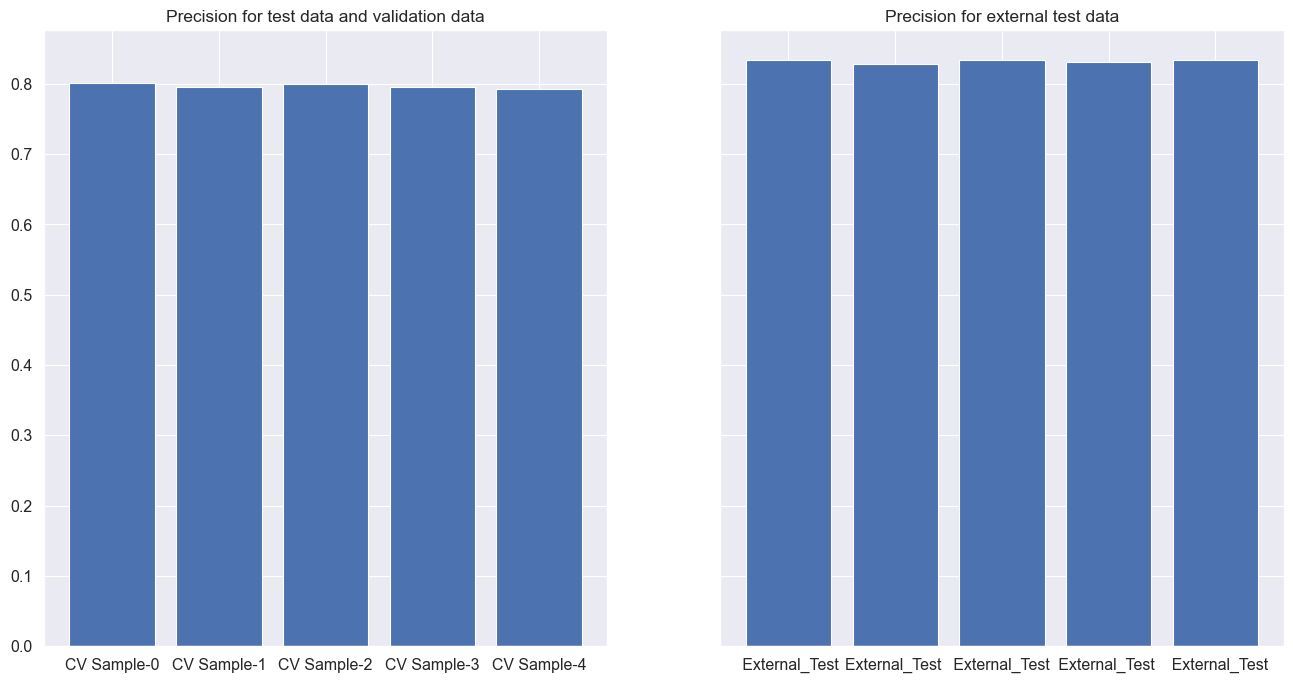

In [7]:
#model_use = XGBClassifier(n_estimators=500,random_state=1,n_jobs=-1,tree_method = 'gpu_hist')
test_tree_cost,external_tree_cost = get_metrics(model=model_use,
                                                  data_dict=data_dict,
                                                  problem_type = 'classification',
                                                  dependent_variable=dependent_variable,
                                                  features=best_columns_PSO_HotelCancel_lightgbm,
                                                  cost_funct=cost_funct)
print('Average Test and Validation Cost:',round(np.mean(list(test_tree_cost.values())),2),'Average External Test Cost:',round(np.mean(external_tree_cost),2))
metric = 'Precision'
title = 'Hotel Cancellations dataset - Particle Swarm Optimization'
print(title)
make_plot(metric=metric,
          title=title,
          test_tree_cost=test_tree_cost,
          external_tree_cost=external_tree_cost)


External Test recall: 0.83
Average Test and Validation Cost: 0.82 Average External Test Cost: 0.83
Hotel Cancellations dataset - Ant Colony Optimization


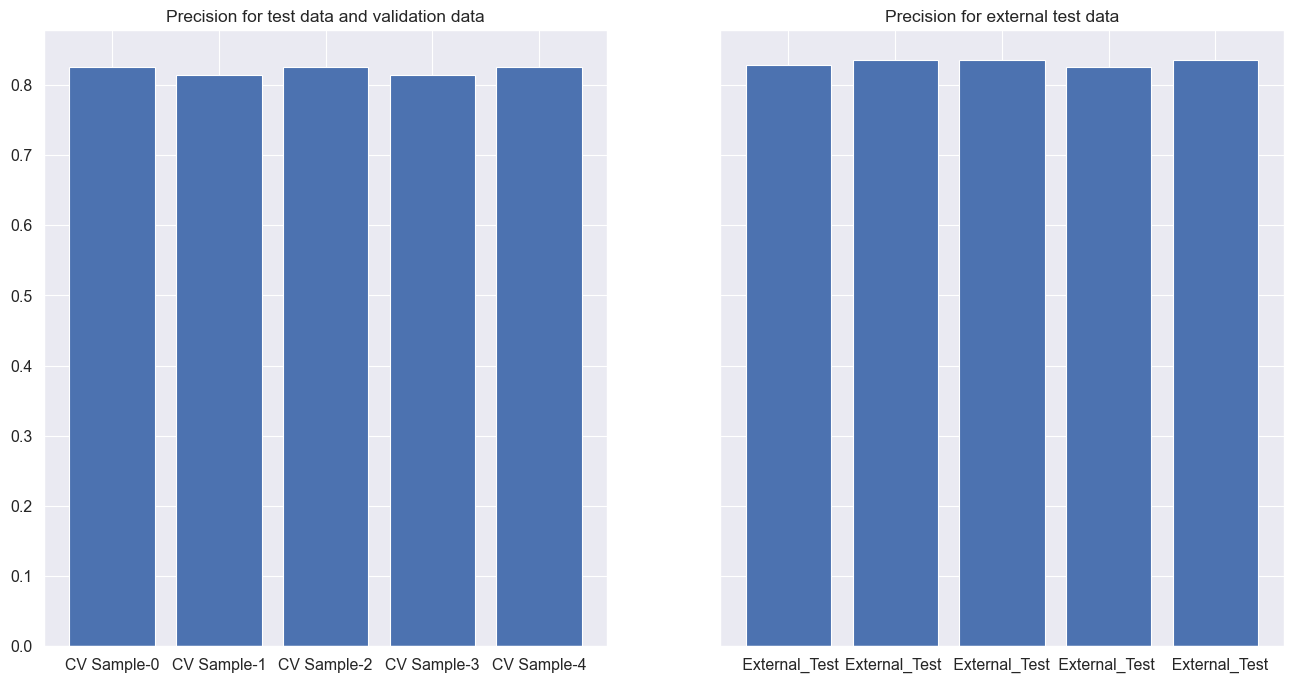

In [9]:
#model_use = XGBClassifier(n_estimators=500,random_state=1,n_jobs=-1)#,tree_method = 'gpu_hist')
test_tree_cost,external_tree_cost = get_metrics(model=model_use,
                                                  data_dict=data_dict,
                                                  problem_type = 'classification',
                                                  dependent_variable=dependent_variable,
                                                  features=best_columns_ACO_HotelCancel_lightgbm,
                                                  cost_funct=cost_funct)

print('Average Test and Validation Cost:',round(np.mean(list(test_tree_cost.values())),2),'Average External Test Cost:',round(np.mean(external_tree_cost),2))
metric = 'Precision'
title = 'Hotel Cancellations dataset - Ant Colony Optimization'
print(title)
make_plot(metric=metric,
          title=title,
          test_tree_cost=test_tree_cost,
          external_tree_cost=external_tree_cost)


External Test recall: 0.83
Average Test and Validation Cost: 0.83 Average External Test Cost: 0.83
Hotel Cancellations dataset - Simulated Annealing


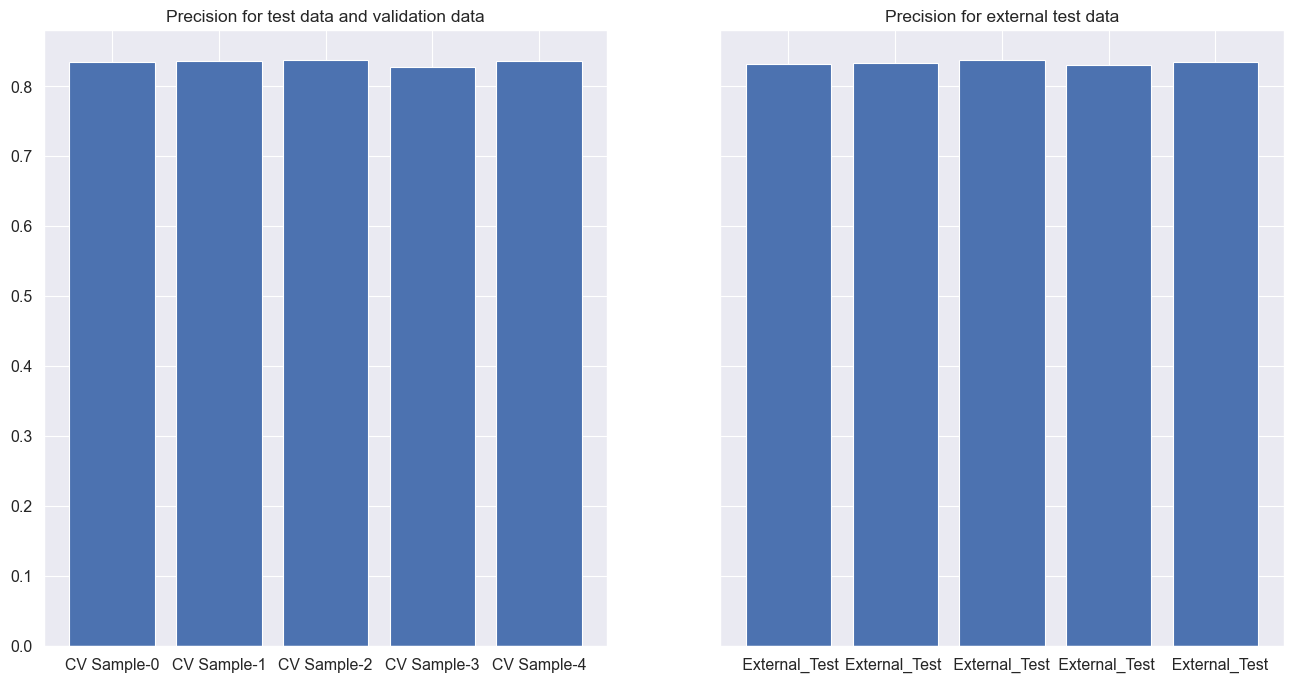

In [11]:
#model_use = XGBClassifier(n_estimators=200,random_state=1,n_jobs=-1)
test_tree_cost,external_tree_cost = get_metrics(model=model_use,
                                                  data_dict=data_dict,
                                                  problem_type = 'classification',
                                                  dependent_variable=dependent_variable,
                                                  features=best_columns_SA_HotelCancel_lightgbm,
                                                  cost_funct=cost_funct)

print('Average Test and Validation Cost:',round(np.mean(list(test_tree_cost.values())),2),'Average External Test Cost:',round(np.mean(external_tree_cost),2))
metric = 'Precision'
title = 'Hotel Cancellations dataset - Simulated Annealing'
print(title)
make_plot(metric=metric,
          title=title,
          test_tree_cost=test_tree_cost,
          external_tree_cost=external_tree_cost)


External Test recall: 0.83
Average Test and Validation Cost: 0.83 Average External Test Cost: 0.83
Hotel Cancellations dataset - Genetic Algorithm


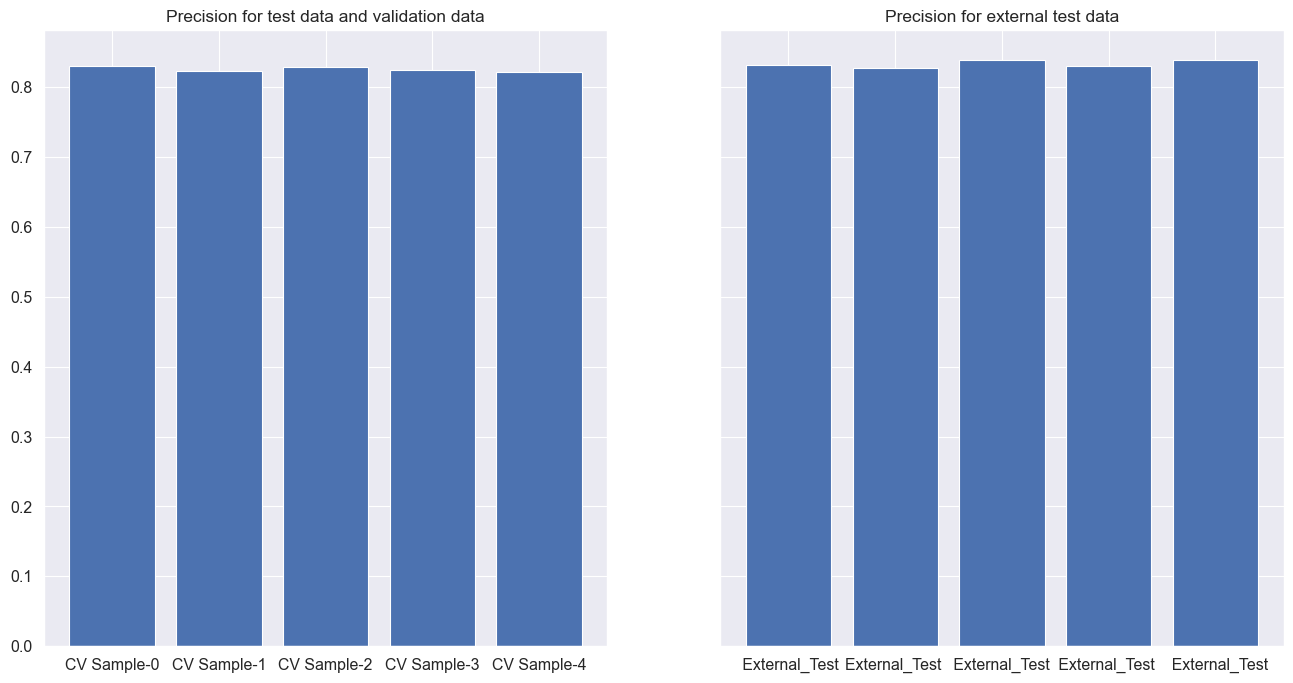

In [13]:
#model_use = XGBClassifier(n_estimators=500,random_state=1,n_jobs=-1,tree_method = 'gpu_hist')
test_tree_cost,external_tree_cost = get_metrics(model=model_use,
                                                  data_dict=data_dict,
                                                  problem_type = 'classification',
                                                  dependent_variable=dependent_variable,
                                                  features=best_columns_GA_HotelCancel_lightgbm,
                                                  cost_funct=cost_funct)

print('Average Test and Validation Cost:',round(np.mean(list(test_tree_cost.values())),2),'Average External Test Cost:',round(np.mean(external_tree_cost),2))
metric = 'Precision'
title = 'Hotel Cancellations dataset - Genetic Algorithm'
print(title)
make_plot(metric=metric,
          title=title,
          test_tree_cost=test_tree_cost,
          external_tree_cost=external_tree_cost)


## Xgboost

In [23]:
# model_use = LGBMRegressor(random_state=1,n_jobs=-1,n_estimators=100)
model_use = XGBClassifier(n_estimators=200,random_state=1,n_jobs=-1,tree_method = 'gpu_hist')
# model_use = RandomForestRegressor(random_state=1,n_jobs=-1,n_estimators=200)

fsObj = FeatureSelection(columns_list = tree_features_all,
                         data_dict = data_dict_for_tree,
                         x_validation_dataframe = x_validation_tree,
                         y_validation_dataframe = y_validation_tree,
                         model = model_use,
                         cost_function = cost_funct,
                         cost_function_improvement = 'increase',
                         average = None)

In [6]:
#### Particle Swarm Optimization
best_columns_PSO_HotelCancel_xgboost = fsObj.ParticleSwarmOptimization(iterations = 25,                                                                   
                                                                       swarmSize = 75,
                                                                       run_time=1200)

with open(r"D:\\Results\\ResultPickle\\best_columns_PSO_HotelCancel_xgboost.pickle", "wb") as output_file:
    pickle.dump(best_columns_PSO_HotelCancel_xgboost, output_file)

Best combined performance on test and validation data for iteration 0: 0.8244271829323939
Best combined performance on test and validation data for iteration 1: 0.8421729271692419
Best combined performance on test and validation data for iteration 2: 0.8421729271692419
Best combined performance on test and validation data for iteration 3: 0.8421729271692419
Best combined performance on test and validation data for iteration 4: 0.8421729271692419
Best combined performance on test and validation data for iteration 5: 0.8421729271692419
Best combined performance on test and validation data for iteration 6: 0.8421729271692419
Best combined performance on test and validation data for iteration 7: 0.8421729271692419
Best combined performance on test and validation data for iteration 8: 0.8421729271692419
Best combined performance on test and validation data for iteration 9: 0.8421729271692419
Best combined performance on test and validation data for iteration 10: 0.8421729271692419
Best comb

In [12]:
#### Ant Colony Optimization
best_columns_ACO_HotelCancel_xgboost = fsObj.AntColonyOptimization(iterations = 25,
                                                                N_ants = 75,
                                                                run_time=1200,
                                                                evaporation_rate=0.8,
                                                                Q=0.2)

with open(r"D:\\Results\\ResultPickle\\best_columns_ACO_HotelCancel_xgboost.pickle", "wb") as output_file:
    pickle.dump(best_columns_ACO_HotelCancel_xgboost, output_file)

Best combined performance on test and validation data for iteration 0: 0.8367793318458914
Best combined performance on test and validation data for iteration 1: 0.8521934941187854
Best combined performance on test and validation data for iteration 2: 0.8552180885138283
Best combined performance on test and validation data for iteration 3: 0.8570069898519017
Best combined performance on test and validation data for iteration 4: 0.8570069898519017
Best combined performance on test and validation data for iteration 5: 0.8570069898519017
Best combined performance on test and validation data for iteration 6: 0.8573772222260324
Best combined performance on test and validation data for iteration 7: 0.8573772222260324
Best combined performance on test and validation data for iteration 8: 0.8573772222260324
Best combined performance on test and validation data for iteration 9: 0.8573772222260324
Best combined performance on test and validation data for iteration 10: 0.8573772222260324
Best comb

In [33]:
#### Simulated Annealing
best_columns_SA_HotelCancel_xgboost = fsObj.SimulatedAnnealing(temperature = 1500,
                                                               iterations = 35,
                                                               n_perturb = 75,
                                                               run_time=1200,
                                                               n_features_percent_perturb=1,
                                                               alpha=0.9)

with open(r"D:\\Results\\ResultPickle\\best_columns_SA_HotelCancel_xgboost.pickle", "wb") as output_file:
    pickle.dump(best_columns_SA_HotelCancel_xgboost, output_file)

Best combined performance on test and validation data for iteration 0: 0.7167448383370251
Best combined performance on test and validation data for iteration 1: 0.7235161125829991
Best combined performance on test and validation data for iteration 2: 0.7325854822984283
Best combined performance on test and validation data for iteration 3: 0.7679653693544285
Best combined performance on test and validation data for iteration 4: 0.7982988050529538
Best combined performance on test and validation data for iteration 5: 0.8298992154982374
Best combined performance on test and validation data for iteration 6: 0.8421314966237313
Best combined performance on test and validation data for iteration 7: 0.8495068538354976
Best combined performance on test and validation data for iteration 8: 0.8629978584506649
Best combined performance on test and validation data for iteration 9: 0.8637098688764088
Best combined performance on test and validation data for iteration 10: 0.8637098688764088
Best comb

In [35]:
#### Genetic Algorithm
best_columns_GA_HotelCancel_xgboost = fsObj.GeneticAlgorithm(generations=20,
                                                             population=75,
                                                             run_time=1200)

with open(r"D:\\Results\\ResultPickle\\best_columns_GA_HotelCancel_xgboost.pickle", "wb") as output_file:
    pickle.dump(best_columns_GA_HotelCancel_xgboost, output_file)

Best combined performance on test and validation data for generation 0 : 0.8335388191254951
Best combined performance on test and validation data for generation 1 : 0.8426055067319773
Best combined performance on test and validation data for generation 2 : 0.8390713701643799
Best combined performance on test and validation data for generation 3 : 0.8386006049279884
Best combined performance on test and validation data for generation 4 : 0.8468804107743809
Best combined performance on test and validation data for generation 5 : 0.8518674037953382
Best combined performance on test and validation data for generation 6 : 0.8482528559153735
Best combined performance on test and validation data for generation 7 : 0.8500596380719708
Best combined performance on test and validation data for generation 8 : 0.8535473531008269
Best combined performance on test and validation data for generation 9 : 0.856882402507962
Best combined performance on test and validation data for generation 10 : 0.85456

External Test recall: 0.64
Average Test and Validation Cost: 0.84 Average External Test Cost: 0.88
Hotel Cancellations dataset - Particle Swarm Optimization


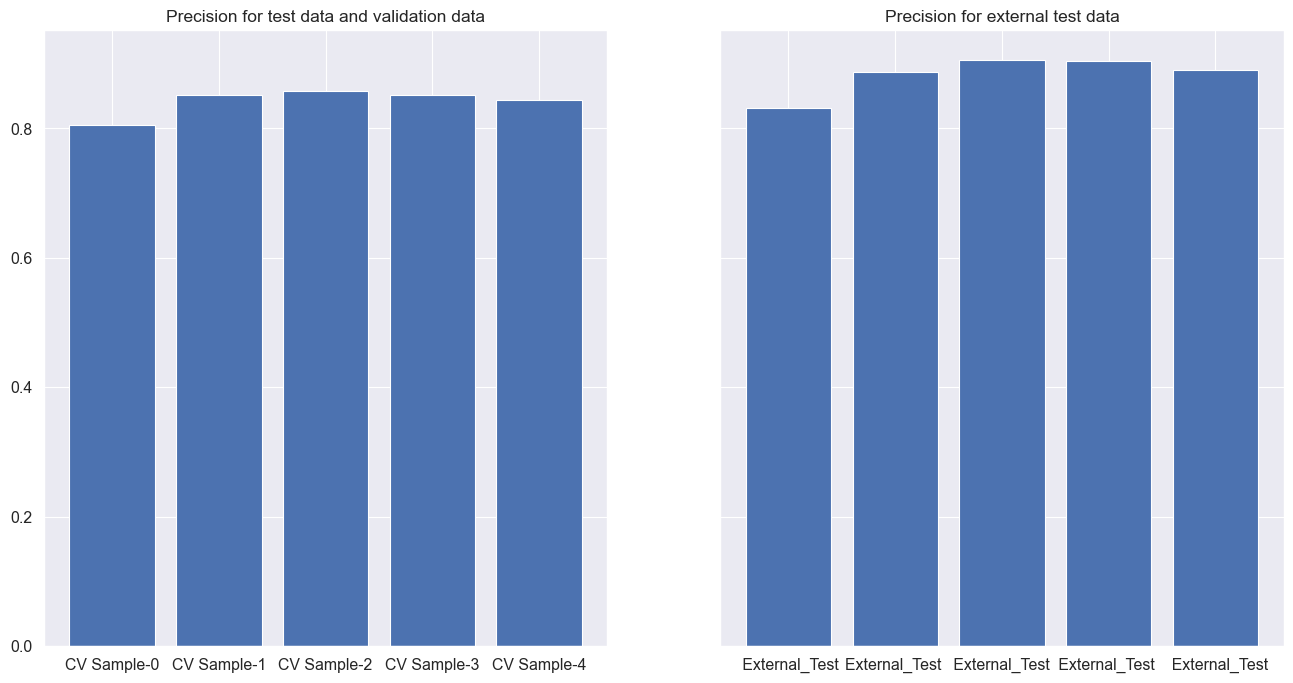

In [48]:
#model_use = XGBClassifier(n_estimators=500,random_state=1,n_jobs=-1,tree_method = 'gpu_hist')
test_tree_cost,external_tree_cost = get_metrics(model=model_use,
                                                  data_dict=data_dict,
                                                  problem_type = 'classification',
                                                  dependent_variable=dependent_variable,
                                                  features=best_columns_PSO_HotelCancel_xgboost,
                                                  cost_funct=cost_funct)
print('Average Test and Validation Cost:',round(np.mean(list(test_tree_cost.values())),2),'Average External Test Cost:',round(np.mean(external_tree_cost),2))
metric = 'Precision'
title = 'Hotel Cancellations dataset - Particle Swarm Optimization'
print(title)
make_plot(metric=metric,
          title=title,
          test_tree_cost=test_tree_cost,
          external_tree_cost=external_tree_cost)

External Test recall: 0.52
Average Test and Validation Cost: 0.86 Average External Test Cost: 0.91
Hotel Cancellations dataset - Ant Colony Optimization


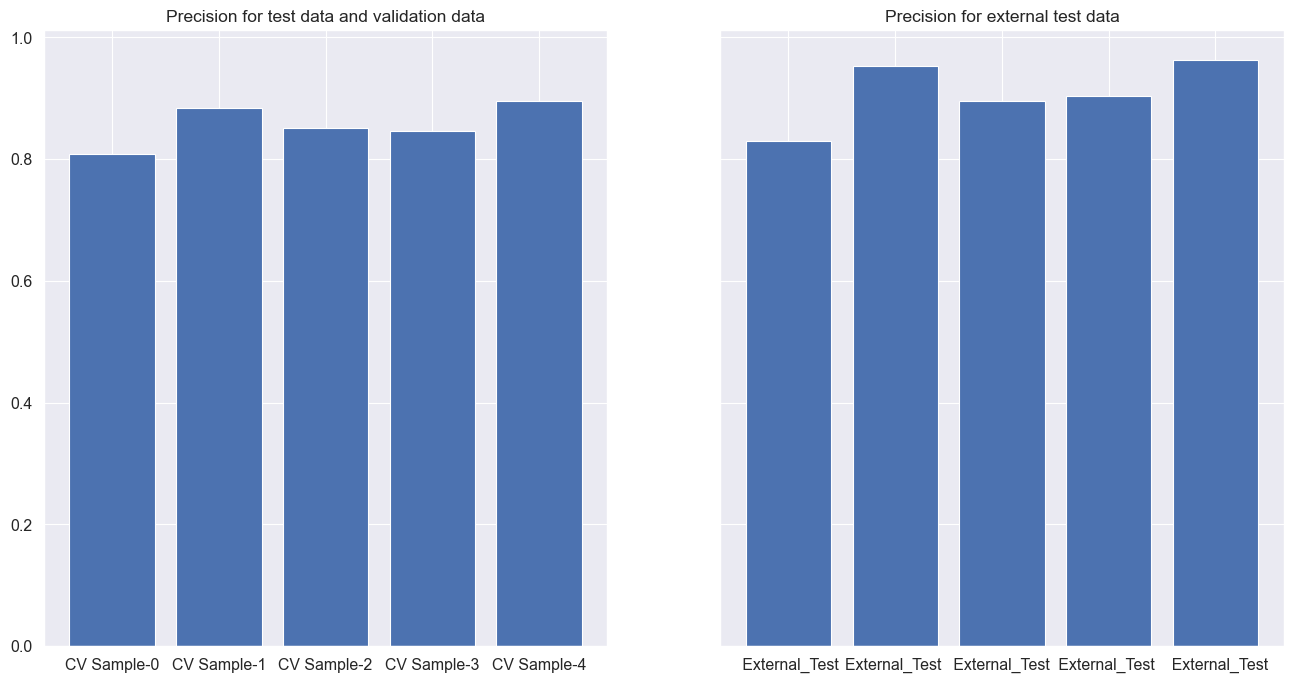

In [49]:
#model_use = XGBClassifier(n_estimators=500,random_state=1,n_jobs=-1)#,tree_method = 'gpu_hist')
test_tree_cost,external_tree_cost = get_metrics(model=model_use,
                                                  data_dict=data_dict,
                                                  problem_type = 'classification',
                                                  dependent_variable=dependent_variable,
                                                  features=best_columns_ACO_HotelCancel_xgboost,
                                                  cost_funct=cost_funct)

print('Average Test and Validation Cost:',round(np.mean(list(test_tree_cost.values())),2),'Average External Test Cost:',round(np.mean(external_tree_cost),2))
metric = 'Precision'
title = 'Hotel Cancellations dataset - Ant Colony Optimization'
print(title)
make_plot(metric=metric,
          title=title,
          test_tree_cost=test_tree_cost,
          external_tree_cost=external_tree_cost)

External Test recall: 0.4
Average Test and Validation Cost: 0.88 Average External Test Cost: 0.93
Hotel Cancellations dataset - Simulated Annealing


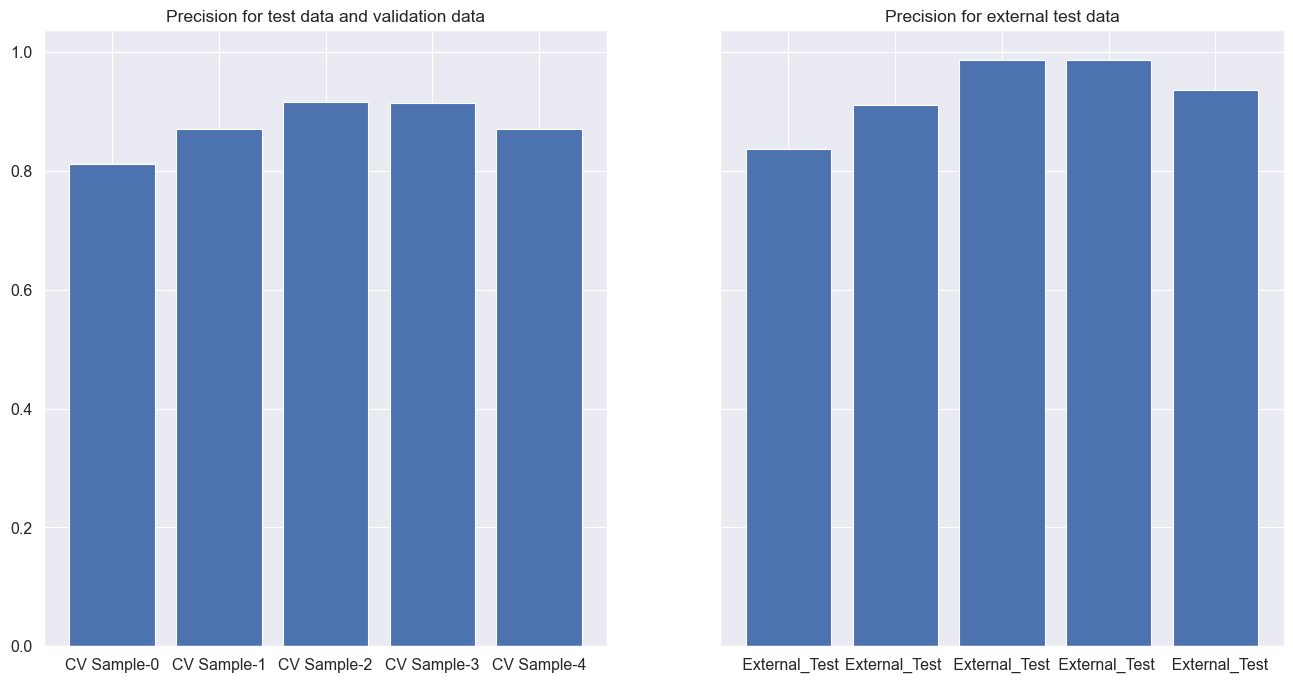

In [50]:
#model_use = XGBClassifier(n_estimators=200,random_state=1,n_jobs=-1)
test_tree_cost,external_tree_cost = get_metrics(model=model_use,
                                                  data_dict=data_dict,
                                                  problem_type = 'classification',
                                                  dependent_variable=dependent_variable,
                                                  features=best_columns_SA_HotelCancel_xgboost,
                                                  cost_funct=cost_funct)

print('Average Test and Validation Cost:',round(np.mean(list(test_tree_cost.values())),2),'Average External Test Cost:',round(np.mean(external_tree_cost),2))
metric = 'Precision'
title = 'Hotel Cancellations dataset - Simulated Annealing'
print(title)
make_plot(metric=metric,
          title=title,
          test_tree_cost=test_tree_cost,
          external_tree_cost=external_tree_cost)

External Test recall: 0.41
Average Test and Validation Cost: 0.86 Average External Test Cost: 0.92
Hotel Cancellations dataset - Genetic Algorithm


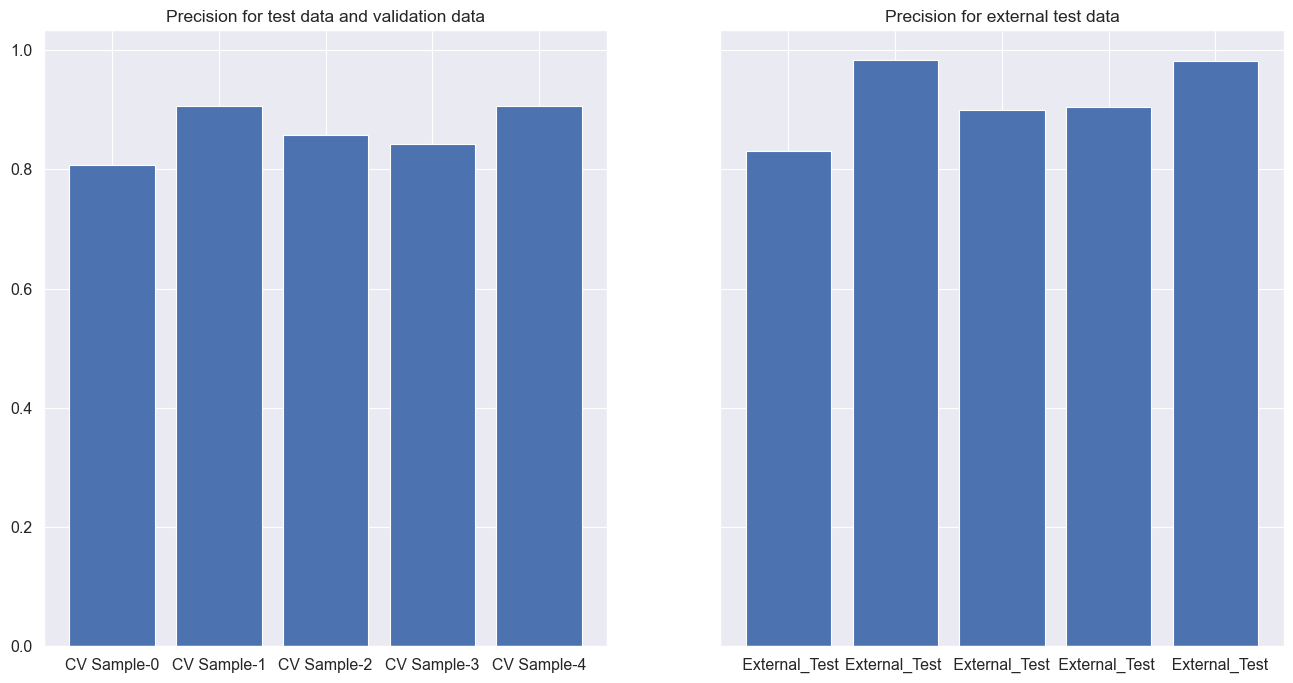

In [51]:
#model_use = XGBClassifier(n_estimators=500,random_state=1,n_jobs=-1,tree_method = 'gpu_hist')
test_tree_cost,external_tree_cost = get_metrics(model=model_use,
                                                  data_dict=data_dict,
                                                  problem_type = 'classification',
                                                  dependent_variable=dependent_variable,
                                                  features=best_columns_GA_HotelCancel_xgboost,
                                                  cost_funct=cost_funct)

print('Average Test and Validation Cost:',round(np.mean(list(test_tree_cost.values())),2),'Average External Test Cost:',round(np.mean(external_tree_cost),2))
metric = 'Precision'
title = 'Hotel Cancellations dataset - Genetic Algorithm'
print(title)
make_plot(metric=metric,
          title=title,
          test_tree_cost=test_tree_cost,
          external_tree_cost=external_tree_cost)

## Logistic Regression

In [7]:
patch_sklearn()
model_use = LogisticRegression(random_state=1,n_jobs=-1)

fsObj = FeatureSelection(columns_list = linear_features_all,
                         data_dict = data_dict_for_linear,
                         x_validation_dataframe = x_validation_linear,
                         y_validation_dataframe = y_validation_linear,
                         model = model_use,
                         cost_function = cost_funct,
                         cost_function_improvement = 'increase',
                         average = None)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [40]:
#### Particle Swarm Optimization
best_columns_PSO_HotelCancel_logistic = fsObj.ParticleSwarmOptimization(iterations = 25,                                                                   
                                                                       swarmSize = 75,
                                                                       run_time=1200)

with open(r"D:\\Results\\ResultPickle\\best_columns_PSO_HotelCancel_logistic.pickle", "wb") as output_file:
    pickle.dump(best_columns_PSO_HotelCancel_logistic, output_file)

Best combined performance on test and validation data for iteration 0: 0.6930952380952381
Best combined performance on test and validation data for iteration 1: 0.6930952380952381
Best combined performance on test and validation data for iteration 2: 0.725
Best combined performance on test and validation data for iteration 3: 0.756271186440678
Best combined performance on test and validation data for iteration 4: 0.756271186440678
Best combined performance on test and validation data for iteration 5: 0.7615976233701931
Best combined performance on test and validation data for iteration 6: 0.7615976233701931
Best combined performance on test and validation data for iteration 7: 0.7615976233701931
Best combined performance on test and validation data for iteration 8: 0.7615976233701931
Best combined performance on test and validation data for iteration 9: 0.7615976233701931
Best combined performance on test and validation data for iteration 10: 0.7615976233701931
Best combined performanc

In [42]:
#### Ant Colony Optimization
best_columns_ACO_HotelCancel_logistic = fsObj.AntColonyOptimization(iterations = 25,
                                                                N_ants = 75,
                                                                run_time=1200,
                                                                evaporation_rate=0.8,
                                                                Q=0.2)

with open(r"D:\\Results\\ResultPickle\\best_columns_ACO_HotelCancel_logistic.pickle", "wb") as output_file:
    pickle.dump(best_columns_ACO_HotelCancel_logistic, output_file)

Best combined performance on test and validation data for iteration 0: 0.6061453853738875
Best combined performance on test and validation data for iteration 1: 0.6061453853738875
Best combined performance on test and validation data for iteration 2: 0.6061453853738875
Best combined performance on test and validation data for iteration 3: 0.6061453853738875
Best combined performance on test and validation data for iteration 4: 0.6061453853738875
Best combined performance on test and validation data for iteration 5: 0.6061453853738875
Best combined performance on test and validation data for iteration 6: 0.6061453853738875
Best combined performance on test and validation data for iteration 7: 0.6061453853738875
Best combined performance on test and validation data for iteration 8: 0.6061453853738875
Best combined performance on test and validation data for iteration 9: 0.6061453853738875
Best combined performance on test and validation data for iteration 10: 0.6061453853738875
Best comb

In [8]:
#### Simulated Annealing
best_columns_SA_HotelCancel_logistic = fsObj.SimulatedAnnealing(temperature = 1500,
                                                               iterations = 35,
                                                               n_perturb = 75,
                                                               run_time=1200,
                                                               n_features_percent_perturb=1,
                                                               alpha=0.9)

with open(r"D:\\Results\\ResultPickle\\best_columns_SA_HotelCancel_logistic.pickle", "wb") as output_file:
    pickle.dump(best_columns_SA_HotelCancel_logistic, output_file)

Best combined performance on test and validation data for iteration 0: 0.5644444444444444
Best combined performance on test and validation data for iteration 1: 0.5696793381384174
Best combined performance on test and validation data for iteration 2: 0.5853146430352831
Best combined performance on test and validation data for iteration 3: 0.5863837433273799
Best combined performance on test and validation data for iteration 4: 0.6863388423456264
Best combined performance on test and validation data for iteration 5: 0.6819483694523936
Best combined performance on test and validation data for iteration 6: 0.7052742410530978
Best combined performance on test and validation data for iteration 7: 0.7061374060800186
Best combined performance on test and validation data for iteration 8: 0.7056052925624682
Best combined performance on test and validation data for iteration 9: 0.7052742410530978
Best combined performance on test and validation data for iteration 10: 0.7076994956954682
Best comb

In [10]:
#### Genetic Algorithm
best_columns_GA_HotelCancel_logistic = fsObj.GeneticAlgorithm(generations=20,
                                                             population=75,
                                                             run_time=1200)

with open(r"D:\\Results\\ResultPickle\\best_columns_GA_HotelCancel_logistic.pickle", "wb") as output_file:
    pickle.dump(best_columns_GA_HotelCancel_logistic, output_file)

Best combined performance on test and validation data for generation 0 : 0.5902881218067784
Best combined performance on test and validation data for generation 1 : 0.5892286062789036
Best combined performance on test and validation data for generation 2 : 0.5920887836221107
Best combined performance on test and validation data for generation 3 : 0.5920859882590694
Best combined performance on test and validation data for generation 4 : 0.5909966228730517
Best combined performance on test and validation data for generation 5 : 0.5910900161625708
Best combined performance on test and validation data for generation 6 : 0.5910196922949658
Best combined performance on test and validation data for generation 7 : 0.6043108387297329
Best combined performance on test and validation data for generation 8 : 0.599796681212791
Best combined performance on test and validation data for generation 9 : 0.6006203096781776
Best combined performance on test and validation data for generation 10 : 0.59451

External Test recall: 0.02
Average Test and Validation Cost: 0.79 Average External Test Cost: 1.0
Hotel Cancellations dataset - Particle Swarm Optimization


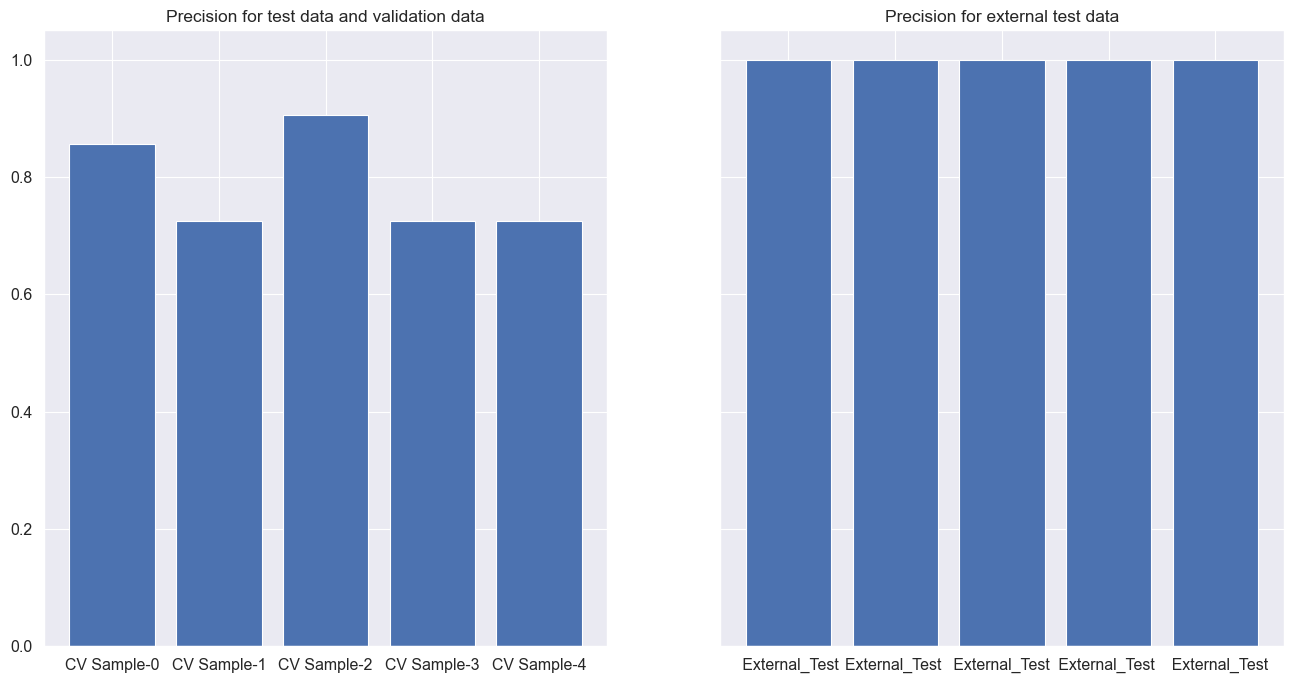

In [41]:
#model_use = XGBClassifier(n_estimators=500,random_state=1,n_jobs=-1,tree_method = 'gpu_hist')
test_tree_cost,external_tree_cost = get_metrics(model=model_use,
                                                  data_dict=data_dict,
                                                  problem_type = 'classification',
                                                  dependent_variable=dependent_variable,
                                                  features=best_columns_PSO_HotelCancel_logistic,
                                                  cost_funct=cost_funct)
print('Average Test and Validation Cost:',round(np.mean(list(test_tree_cost.values())),2),'Average External Test Cost:',round(np.mean(external_tree_cost),2))
metric = 'Precision'
title = 'Hotel Cancellations dataset - Particle Swarm Optimization'
print(title)
make_plot(metric=metric,
          title=title,
          test_tree_cost=test_tree_cost,
          external_tree_cost=external_tree_cost)

External Test recall: 0.17
Average Test and Validation Cost: 0.6 Average External Test Cost: 0.86
Hotel Cancellations dataset - Ant Colony Optimization


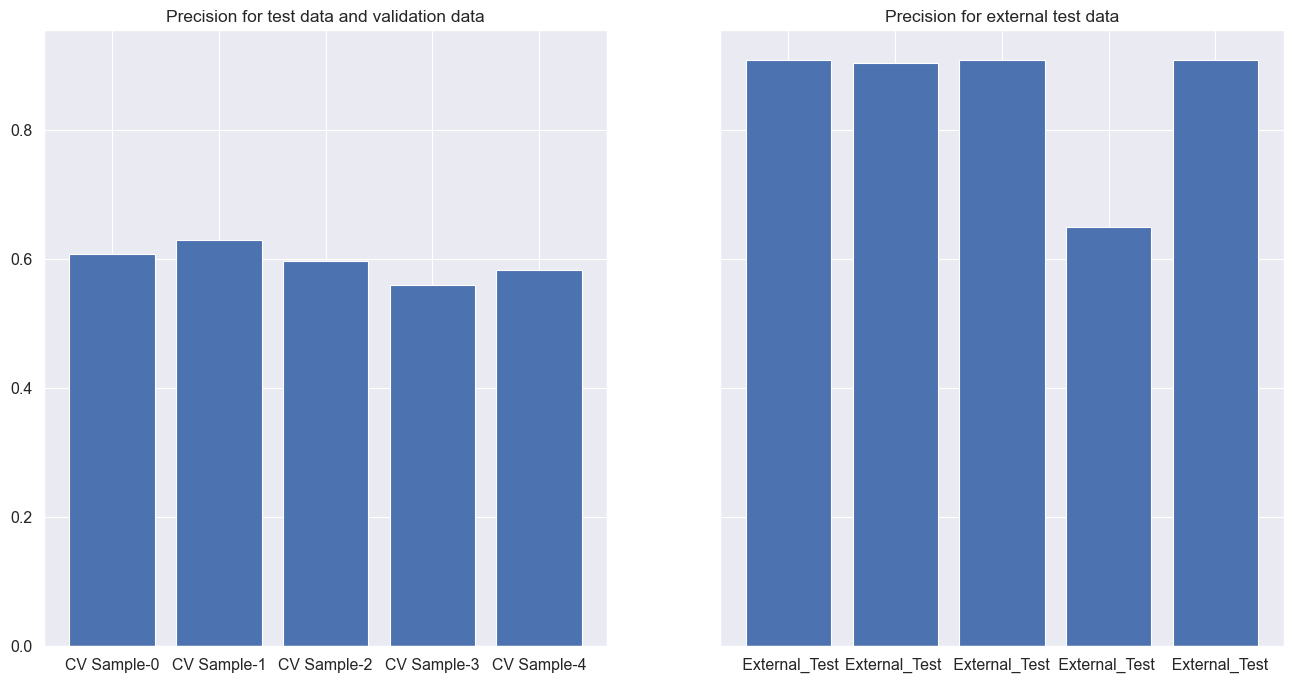

In [43]:
test_tree_cost,external_tree_cost = get_metrics(model=model_use,
                                                  data_dict=data_dict,
                                                  problem_type = 'classification',
                                                  dependent_variable=dependent_variable,
                                                  features=best_columns_ACO_HotelCancel_logistic,
                                                  cost_funct=cost_funct)

print('Average Test and Validation Cost:',round(np.mean(list(test_tree_cost.values())),2),'Average External Test Cost:',round(np.mean(external_tree_cost),2))
metric = 'Precision'
title = 'Hotel Cancellations dataset - Ant Colony Optimization'
print(title)
make_plot(metric=metric,
          title=title,
          test_tree_cost=test_tree_cost,
          external_tree_cost=external_tree_cost)

External Test recall: 0.01
Average Test and Validation Cost: 0.71 Average External Test Cost: 0.71
Hotel Cancellations dataset - Simulated Annealing


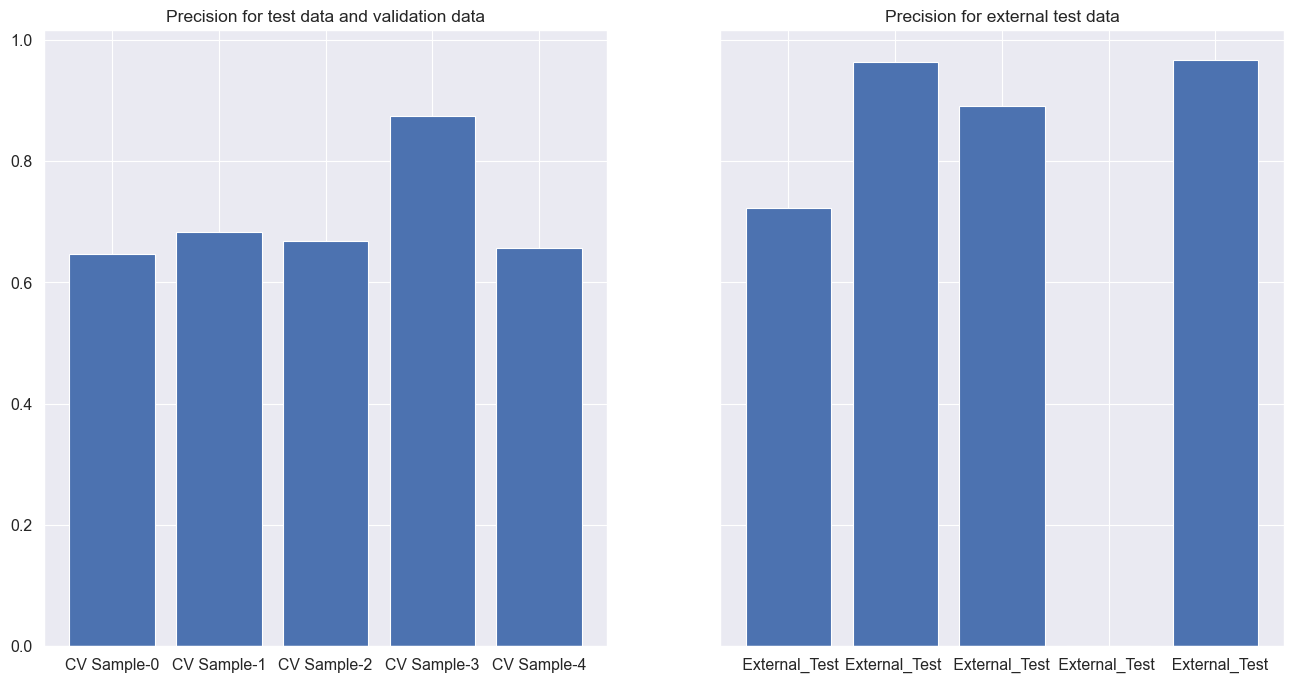

In [9]:
test_tree_cost,external_tree_cost = get_metrics(model=model_use,
                                                  data_dict=data_dict,
                                                  problem_type = 'classification',
                                                  dependent_variable=dependent_variable,
                                                  features=best_columns_SA_HotelCancel_logistic,
                                                  cost_funct=cost_funct)

print('Average Test and Validation Cost:',round(np.mean(list(test_tree_cost.values())),2),'Average External Test Cost:',round(np.mean(external_tree_cost),2))
metric = 'Precision'
title = 'Hotel Cancellations dataset - Simulated Annealing'
print(title)
make_plot(metric=metric,
          title=title,
          test_tree_cost=test_tree_cost,
          external_tree_cost=external_tree_cost)

External Test recall: 0.15
Average Test and Validation Cost: 0.6 Average External Test Cost: 0.95
Hotel Cancellations dataset - Genetic Algorithm


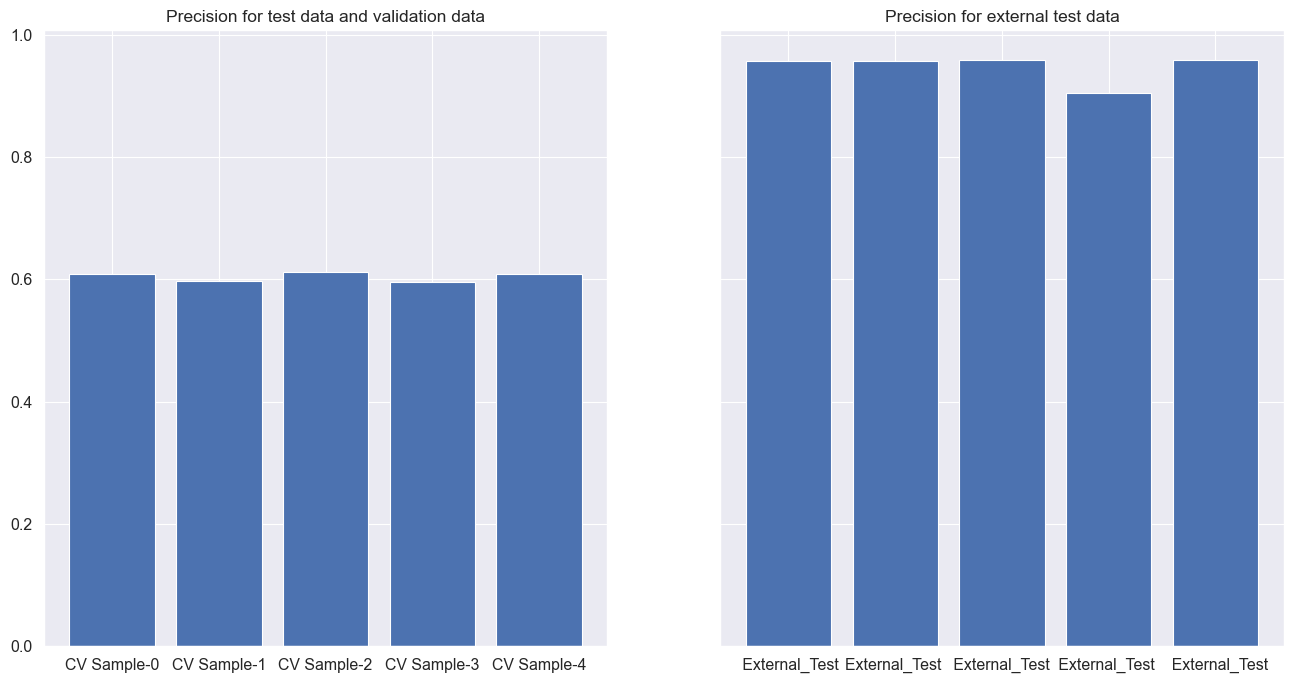

In [11]:
test_tree_cost,external_tree_cost = get_metrics(model=model_use,
                                                  data_dict=data_dict,
                                                  problem_type = 'classification',
                                                  dependent_variable=dependent_variable,
                                                  features=best_columns_GA_HotelCancel_logistic,
                                                  cost_funct=cost_funct)

print('Average Test and Validation Cost:',round(np.mean(list(test_tree_cost.values())),2),'Average External Test Cost:',round(np.mean(external_tree_cost),2))
metric = 'Precision'
title = 'Hotel Cancellations dataset - Genetic Algorithm'
print(title)
make_plot(metric=metric,
          title=title,
          test_tree_cost=test_tree_cost,
          external_tree_cost=external_tree_cost)

In [12]:
unpatch_sklearn()